# Introduction
We're going to a quick experiment to see how link prediction and node classification relate to one another. To do this, we will impliment a graph autoencoder (GAE). This will take as input a graph G, consisting of nodes V, edges, E, and features associated with each node, X.

Before we start, please make sure you have python 3 installed, and pip. It's recommended you create a new python environment (though not required), then use `pip install -r requirements.txt` in the command line

In [9]:
import torch # Neural network module
from torch import nn 
from torch_geometric.nn import MessagePassing # Graph neural network module

If the above cell did not execute, make sure you double check that this notebook is using the python environment that imported the `requirements.txt` file. 

# Getting some data
Let's get a simple dataset to play with. `torch_geometric` provides a few we can use to get started. The below code will download a small dataset to this dirctory and allow us to get started.

In [7]:
from torch_geometric.datasets import KarateClub
g = KarateClub()

print(f"{g.x.size(0)} nodes")
print(f"{g.x.size(1)} features")
print(f"{g.edge_index.size(1)} edges")
print(f"{g.y.max()+1} labels")

34 nodes
34 features
156 edges
4 labels


Torch Geometric graphs are structured as a matrix of features `X` and a list of classes for each feature `y`, which is pretty standard for machine learning. They differ from normal machine learning datasets with the introduction of the `edge_index` field. This is a 2x|E| dimensional matrix of edges. The top row represents the source node, and the bottom row represents the destination node for the edge. Let's see how this looks:

In [8]:
# The first 10 edges
g.edge_index[:,:10]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11]])

The first ten edges all originate from node 0. They point to nodes 1-11. This dataset is a social network of a karate class. Here, nodes represent students, and edges represent that a student is friends with another. 

# Building our first GNN
Now that we've seen what the data looks like, let's look at how to do message passing. Luckilly, `torch_geometric` makes this pretty easy. 

In [13]:
mp = MessagePassing(aggr='mean')

# As an example, make a graph with 5 nodes, 
# with the identity matrix as the node features
x_example = torch.eye(5)

# And we'll just add some random edges. Each node points to the next one
# in a big circular structure
ei_example = torch.tensor([
    [0,1,2,3,4],
    [1,2,3,4,0]
])

print("X")
print(x_example)

# To pass messages (features) from a node to its neighbors 
# just use the propagate method of the MessagePassing object
print("\nPropagated messages")
print(mp.propagate(ei_example, x=x_example))

X
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

Propagated messages
tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])


As expected, the matrix of passed messages is shifted down one. As if each node in the graph shifted by one. Great. With this basic mechanic in mind, try it on your own with the karate club dataset:

In [14]:
print('X')
print(g.x)

print("\nPropagated messages")

# Use mp.propagate to do one message-passing step on `g`

X
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Propagated messages


Great. Now let's get a little more advanced. Let's include the feature aggregation step, and make a whole pytorch module

In [15]:
class MyGCN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        # First we want it to pass messages
        self.mp = MessagePassing(aggr='mean')

        # Then we want it to aggregate those messages using 
        # a nonlinear projection. Here, we'll use a linear layer
        # and put a nonlinearity on the output later
        self.mlp = nn.Linear(in_dim, out_dim)
    
    def forward(self, x, edge_index):
        x = self.mp.propagate(edge_index, x=x)
        return self.mlp(x)

Let's take the new GCN out for a spin. Try passing it the karate club data

In [18]:
# We'll project to 16 dimensions, but feel free to experiment with this value
# and see how it changes the results
gcn = MyGCN(g.x.size(1), 16) 

# Add your code here:

Great! Now let's stack a few together and make a whole neural network. 

In [23]:
class MyGCNModule(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layers=2):
        super().__init__()
        self.gcns = nn.ModuleList(
            [MyGCN(in_dim, hidden_dim)] + 
            [MyGCN(hidden_dim, hidden_dim) for _ in range(layers-2)] + 
            [MyGCN(hidden_dim, out_dim)]
        )
        self.bce = nn.BCELoss()
    
    def embed(self, x, edge_index):
        for gcn in self.gcns[:-1]:
            x = gcn(x, edge_index)
            x = torch.relu(x)
        
        # No activation on the last one
        return self.gcns[-1](x, edge_index)
    
    def connection_probability(self, z, edges):
        '''
        Take the dot product of two nodes embeddings to 
        determine if they're connected
        '''
        return torch.sigmoid(
            (z[edges[0]] * z[edges[1]]).sum(dim=1)
        )

    def calc_loss(self, z, edge_index):
        # Generate a list of non-edges
        fake_edges = torch.randint(0, edge_index.max(), edge_index.size())
        
        # We are classifying links as probable or non-probable. 
        # Thus, we generate some fake edges, and say their class is 0
        # and real edges have a target class of 1 
        targets = torch.zeros(edge_index.size(1)*2)
        targets[:edge_index.size(1)] = 1 

        edges = torch.cat([edge_index, fake_edges], dim=1)
        preds = self.connection_probability(z, edges)
        
        # Take binary cross entropy loss on outputs. Tells model to make
        # the dot product of neighhbors closer to 1 (vectors are parallel)
        # and dot product of non-neighbors closer to 0 (vectors are orthogonal)
        loss = self.bce(preds, targets)
        return loss 
    
    def forward(self, x, edge_index):
        '''
        Every training step, create node embeddings and
        calculate loss on how well they summarize nodes' neighborhoods
        '''
        z = self.embed(x, edge_index)
        return self.calc_loss(z, edge_index)


In [28]:
from torch.optim import Adam 
from types import SimpleNamespace

# Feel free to mess with these and see how it affects the results
HP = SimpleNamespace(
    hidden=32, out=2, layers=2, 
    lr=0.01, epochs=500
)
model = MyGCNModule(g.x.size(1), HP.hidden, HP.out, HP.layers)
opt = Adam(model.parameters(), lr=HP.lr) 

for e in range(HP.epochs):
    model.train()
    opt.zero_grad()
    loss = model.forward(g.x, g.edge_index)
    loss.backward()
    opt.step()

    if e % 10 == 9:
        print(f"[{e}] {loss.item()}\r", end='')

with torch.no_grad():
    model.eval()
    z = model.embed(g.x, g.edge_index)

Great, now that we've trained our model, let's see what the results look like

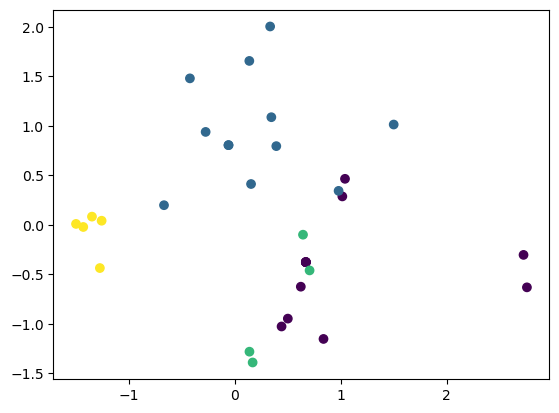

In [30]:
import matplotlib.pyplot as plt 
plt.scatter(z[:,0], z[:,1], c=g.y)
plt.show()

Note that colors represent nodes' classes (in this case, when the karate club had a huge argument and broke up, which friend groups remained intact). Do you notice anything interesting? Did clusters form? Recall that we never told the GNN any class information. All it knows are the edges in the graph, yet it does a pretty good job of putting the groups where they ended up. 

Feel free to go back and experiment some more with the hyper parameters. In this experiment we used a 2-dimensional embedding space so we could easilly visualize the results, but other modules like `sklearn.decomposition.PCA` can help us visualize higher dimensional data in the 2D plane. 

Feel free to play with this by trying out some other datasets: [See a full list here](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)

If you'd like to get more advanced, explore some of the other GNNs available with `torch_geometric.nn` such as GATConv and GINConv. 

I hope this was a helpful introduction to GNNs!